In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Simple neural network

In [2]:
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
import matplotlib.pyplot as plt

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        #  """
        #     Here we define the layers of the network. We create two fully connected layers
    
        #     Parameters:
        #         input_size: the size of the input, in this case 784 (28x28)
        #         num_classes: the number of classes we want to predict, in this case 10 (0-9)

        # """
        super().__init__()
        self.fc1 = nn.Linear(input_size, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 =nn. Linear(300, 100)
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        #  """
        # x here is the mnist images and we run it through fc1, fc2 that we created above.
        # we also add a ReLU activation function in between and for that (since it has no parameters)
        # I recommend using nn.functional (F)

        # Parameters:
        #     x: mnist images

        # Returns:
        #     out: the output of the network
        # """
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        x = self.fc4(x)
        x = F.softmax(x)
        return x

In [19]:
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 15

In [15]:
# Load Data
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5800965.51it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 152555.58it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1451966.04it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2091855.58it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [21]:
model = NeuralNetwork(input_size=input_size, num_classes=num_classes)

In [22]:
# Loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
# Train Network
train_losses = []

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get to correct shape
        data = data.reshape(data.shape[0], -1)

        # Forward
        scores = model(data)
        loss_val = loss(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss_val.backward()

        # Gradient descent or adam step
        optimizer.step()
        train_losses.append(loss_val.item())

  0%|          | 0/938 [00:00<?, ?it/s]/tmp/ipykernel_24/358093697.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
100%|██████████| 938/938 [00:09<00:00, 94.38it/s]


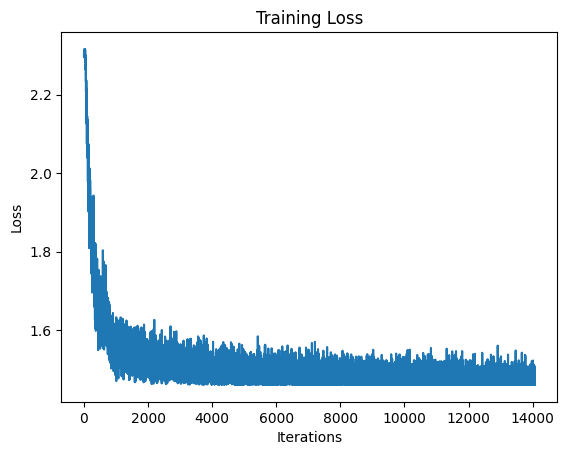

In [24]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [53]:
def check_accuracy(loader, model, reshape = True):
    """
    Check accuracy of our trained model given a loader and a model

    Parameters:
        loader: torch.utils.data.DataLoader
            A loader for the dataset you want to check accuracy on
        model: nn.Module
            The model you want to check accuracy on

    Returns:
        acc: float
            The accuracy of the model on the dataset given by the loader
    """

    num_correct = 0
    num_samples = 0
    model.eval()

    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for x, y in loader:
            # Get to correct shape
            if reshape:
                x = x.reshape(x.shape[0], -1)

            # Forward pass 
            scores = model(x) #64 x 10 matrix 64 is the batch size, 10 is num_classes
            _, predictions = scores.max(1) #give us the maximum value of each row of the matrix and its indice, we can use scores.argmax(1) instead

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

In [27]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model, True)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model, True)*100:.2f}")

/tmp/ipykernel_24/358093697.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Accuracy on training set: 98.56
Accuracy on test set: 97.35


In [ ]:
for layer in model.parameters():
    print(layer.shape)

In [28]:
train_dataset.data[0].shape

torch.Size([28, 28])

# Simple CNNs

In [58]:
class CNN(nn.Module):
    def __init__(self, input_channels = 1, num_classes = 10):
        #  """
        #     Here we define the layers of the network. We create two fully connected layers
    
        #     Parameters:
        #         input_size: the size of the input, in this case 784 (28x28)
        #         num_classes: the number of classes we want to predict, in this case 10 (0-9)

        # """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=(3, 3), padding=1, stride=1)
        self.max_pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=1, stride=1)
        self.fc1 = nn.Linear(14 * 14 * 8, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, num_classes)
        
    
    def forward(self, x):
        #  """
        # x here is the mnist images and we run it through fc1, fc2 that we created above.
        # we also add a ReLU activation function in between and for that (since it has no parameters)
        # I recommend using nn.functional (F)

        # Parameters:
        #     x: mnist images

        # Returns:
        #     out: the output of the network
        # """
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [62]:
cnn_model = CNN()
# Loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [63]:
# Train Network
train_losses = []

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get to correct shape

        # Forward
        scores = cnn_model(data)
        loss_val = loss(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss_val.backward()

        # Gradient descent or adam step
        optimizer.step()
        train_losses.append(loss_val.item())

100%|██████████| 938/938 [00:16<00:00, 55.51it/s]


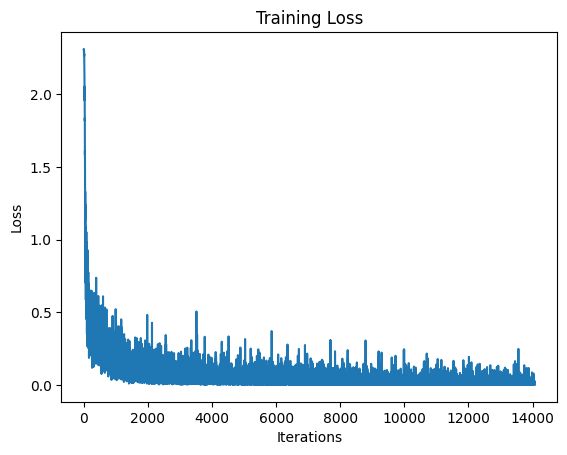

In [64]:
plt.plot(train_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [65]:
print(f"Accuracy on training set: {check_accuracy(train_loader, cnn_model, False)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, cnn_model,False)*100:.2f}")

Accuracy on training set: 99.63
Accuracy on test set: 98.64
